## Motivation: parallax correction of GLM gridded imagery to ground-relative position.

GLM imagery are provided in fixed grid coordinates. When the fixed grid viewing angle `(x,y)` is interscted with the earth to retrieve a `(lat,lon)` pair, there is usually parallax because the cloud surface from which light. The parallax arises because the cloud is at some (unkonwn) height above the ground. When overlaid to other sateliite imagry, this is no problem, and is even desirable, as the fixed grid viewing angle includes no further assumptions - it is the native coordinate of any geostationary satellite sensor. 

While fixed grid coordinates are exact from the point of view of the satellite, it is uncertain where any observed cloud is located with respect to ground. For many applications (e.g., numerical weather prediction; analysis of lightning alongside radar observations) the ground-relative position of that cloud (in latitude and longitude) is needed. The purpose of this notebook is to show how to convert GLM imagery in fixed grid coordiantes to latitude and longitude, including an assumption of the height of the cloud surface from which light was emited.

For illustration this notebook uses the same altitude correction assumed in the GLM L2 data, where each flash is reported as a latitude and longitude that attempts to correct for parallax by assuming a height from which light was emitted. This height is defined by a "lightning ellipsoid" that is slightly larger (14 km and 6 km at the equator and poles, respectively) than the elllipsoid that best approximates mean sea level. One could adapt this technique to use any "best" height: simply assume a different ellipsoid shape - for instance, a constant height offset determined based on that day's observations.

**Our strategy is as follows:**
1. Get the fixed grid position of each pixel.
2. Define a new earth ellipsoid whose surface is the lightning ellipsoid.
3. For each pixel, intersect the fixed grid angle with the lightning ellipsoid.
4. Find the cartesian position of the intersection point with respect to the center of the earth. This is an absolute 3D position that can be mapped to any other coordinates of interest.
5. Find the latitude, longitude, and altitude of the intersection point with respect to the MSL ellipsoid.

Figure 5 of [Bruning et al. (2019, JGR)](https://doi.org/10.1029/2019JD030874) is a helpful reference for visualizing the strategy.

In [1]:
import xarray as xr
import numpy as np
import pyproj as proj4
# print(proj4.pj_ellps['GRS80'])

In [2]:
from glmtools.io.lightning_ellipse import lightning_ellipse_rev
from lmatools.coordinateSystems import CoordinateSystem
from lmatools.grid.fixed import get_GOESR_coordsys

### Load some data

Use the imagery dataset that's included in the GLM repository: 2 July 2018, 0433-0434 UTC. Also load the GLM L2 LCFA point data files.

In [3]:
glm = xr.open_dataset('/Users/ebruning/code/glmtools/glmtools/test/data/conus/2018/Jul/02/OR_GLM-L2-GLMC-M3_G16_s20181830433000_e20181830434000_c20191931535490.nc')
nadir = glm.nominal_satellite_subpoint_lon.data
print(nadir)
# print(glm)

-75.0


In [4]:
l2files = ['/Users/ebruning/code/glmtools/glmtools/test/data/OR_GLM-L2-LCFA_G16_s20181830433000_e20181830433200_c20181830433231.nc',
           '/Users/ebruning/code/glmtools/glmtools/test/data/OR_GLM-L2-LCFA_G16_s20181830433200_e20181830433400_c20181830433424.nc',
           '/Users/ebruning/code/glmtools/glmtools/test/data/OR_GLM-L2-LCFA_G16_s20181830433400_e20181830434000_c20181830434029.nc']
l2s = [xr.open_dataset(ds) for ds in l2files]

The operational ellipse used for parllax was revised in October 2018, and had an equatorial height of 16 km above MSL before that time.

To confirm that we are doing the same thing to the GLM imagery that is done to the L2 data, we will apply that earlir lightning ellipsoid here. If you want to use a different altitude, replace `ltg_ellps_re, ltg_ellps_rp` in the cell below with your own values.

In [5]:
this_ellps=0

# equatorial and polar radii
ltg_ellps_re, ltg_ellps_rp = lightning_ellipse_rev[this_ellps]

### 1. Get the fixed grid position of each pixel.

Get the fixed coordinates of the GLM imagery, and create a 2D mesh. The `(lat, lon)` center position of each pixel varies nonlinearly with repsect to the fixed grid, so we can't just use a 1D `(lat, lon)` array here. Later, one could interpolate to a regular `(lat, lon)` grid.

In [6]:
x_1d = glm.x
y_1d = glm.y

x,y = np.meshgrid(x_1d, y_1d) # Two 2D arrays of fixed grid coordinates
z=np.zeros_like(x)

#### Test our understanding of how fixed grid relates to the non-lightning ellipsoid.

These `(lat, lon)` positions include full parallax.

In [7]:
def finite_max(x):
    good = np.isfinite(x)
    return np.max(x[good])

nadir = glm.nominal_satellite_subpoint_lon.data
print(nadir)
geofixCS, grs80lla = get_GOESR_coordsys(nadir)
lon,lat,alt=grs80lla.fromECEF(*geofixCS.toECEF(x,y,z))
lon.shape = x.shape
lat.shape = y.shape
print(np.nanmin(lon), finite_max(lon), np.nanmin(lat), finite_max(lat))

# Let's see if adding height to the lon lat coords gives different fixed grid
x_with_alt, y_with_alt, z_with_alt = geofixCS.fromECEF(*grs80lla.toECEF(lon,lat,alt+10.0e3))

# x and y don't change, but the z coordinate does, which is odd! What does that mean?
print(finite_max(np.abs(x_with_alt - x)))
print(finite_max(np.abs(y_with_alt - y)))
print(finite_max(np.abs(z_with_alt - z)))
# Ah, multiplying the z-delta by the satellite's height above earth gives 10 km.
print(np.abs(z_with_alt - z).max()*35786023.0)

-75.0
-151.65401995626385 -52.9468738334366 14.57133679145014 56.640120779835975
6.219207746016586e-09
1.0482609280604294e-08
0.00027943870711781473
10000.000000008382


###  2. Define a new earth ellipsoid whose surface is the lightning ellipsoid.

Adapt the built-in glmtools functions to include a parallax correction. The cell below is mostly a copy of the functions used in the cell above, but adjusted to allow for the use of a non-standard earth ellipsoid.

In [8]:
def semiaxes_to_invflattening(semimajor, semiminor):
    """ Calculate the inverse flattening from the semi-major
        and semi-minor axes of an ellipse"""
    rf = semimajor/(semimajor-semiminor)
    return rf

class GeostationaryFixedGridSystemAltEllipse(CoordinateSystem):
    
    def __init__(self, subsat_lon=0.0, subsat_lat=0.0, sweep_axis='y',
                 sat_ecef_height=35785831.0,
                 semimajor_axis=None,
                 semiminor_axis=None,
                 datum='WGS84'):
        """ 
        Satellite height is with respect to an arbitray ellipsoid whose
        shape is given by semimajor_axis (equatorial) and semiminor_axis(polar)
        
        Fixed grid coordinates are in radians.
        """
        rf = semiaxes_to_invflattening(semimajor_axis, semiminor_axis)
        print("Defining alt ellipse for Geostationary with rf=", rf)
        self.ECEFxyz = proj4.Proj(proj='geocent',
            a=semimajor_axis, rf=rf)
        self.fixedgrid = proj4.Proj(proj='geos', lon_0=subsat_lon,
            lat_0=subsat_lat, h=sat_ecef_height, x_0=0.0, y_0=0.0, 
            units='m', sweep=sweep_axis,
            a=semimajor_axis, rf=rf)
        self.h=sat_ecef_height
            
    def toECEF(self, x, y, z):
        X, Y, Z = x*self.h, y*self.h, z*self.h
        return proj4.transform(self.fixedgrid, self.ECEFxyz, X, Y, Z)
        
    def fromECEF(self, x, y, z):
        X, Y, Z = proj4.transform(self.ECEFxyz, self.fixedgrid, x, y, z)
        return X/self.h, Y/self.h, Z/self.h

class GeographicSystemAltEllps(CoordinateSystem):
    """
    Coordinate system defined on the surface of the earth using latitude, 
    longitude, and altitude, referenced by default to the WGS84 ellipse.
    
    Alternately, specify the ellipse shape using an ellipse known
    to pyproj, or [NOT IMPLEMENTED] specify r_equator and r_pole directly. 
    """
    def __init__(self, ellipse='WGS84', datum='WGS84', 
                 r_equator=None, r_pole=None):
        if (r_equator is not None) | (r_pole is not None):
            rf = semiaxes_to_invflattening(r_equator, r_pole)
            print("Defining alt ellipse for Geographic with rf", rf)
            self.ERSlla = proj4.Proj(proj='latlong', #datum=datum,
                                     a=r_equator, rf=rf)
            self.ERSxyz = proj4.Proj(proj='geocent', #datum=datum,
                                     a=r_equator, rf=rf)
        else:
            # lat lon alt in some earth reference system
            self.ERSlla = proj4.Proj(proj='latlong', ellps=ellipse, datum=datum)
            self.ERSxyz = proj4.Proj(proj='geocent', ellps=ellipse, datum=datum)
    def toECEF(self, lon, lat, alt):
        projectedData = np.array(proj4.transform(self.ERSlla, self.ERSxyz, lon, lat, alt ))
        if len(projectedData.shape) == 1:
            return projectedData[0], projectedData[1], projectedData[2]
        else:
            return projectedData[0,:], projectedData[1,:], projectedData[2,:]
        
    def fromECEF(self, x, y, z):
        projectedData = np.array(proj4.transform(self.ERSxyz, self.ERSlla, x, y, z ))
        if len(projectedData.shape) == 1:
            return projectedData[0], projectedData[1], projectedData[2]
        else:
            return projectedData[0,:], projectedData[1,:], projectedData[2,:]


def get_GOESR_coordsys_alt_ellps(sat_lon_nadir=-75.0):
    goes_sweep = 'x' # Meteosat is 'y'
    datum = 'WGS84'
    sat_ecef_height=35786023.0
    geofixcs = GeostationaryFixedGridSystemAltEllipse(subsat_lon=sat_lon_nadir,
                    semimajor_axis=ltg_ellps_re, semiminor_axis=ltg_ellps_rp,
                    datum=datum, sweep_axis=goes_sweep,
                    sat_ecef_height=sat_ecef_height)
    grs80lla = GeographicSystemAltEllps(r_equator=ltg_ellps_re, r_pole=ltg_ellps_rp,
                                datum='WGS84')
    return geofixcs, grs80lla

As we did for the MSL ellipsoid, check that we can round-trip the coordinates with minimal error using the lightning ellipsoid.

In [9]:
geofix_ltg, lla_ltg = get_GOESR_coordsys_alt_ellps(nadir)

lon_ltg0,lat_ltg0,alt_ltg0=lla_ltg.fromECEF(*geofix_ltg.toECEF(x,y,z))
lon_ltg0.shape = x.shape
lat_ltg0.shape = y.shape

x_ltg, y_ltg, z_ltg = geofix_ltg.fromECEF(*lla_ltg.toECEF(lon_ltg0,lat_ltg0,alt_ltg0))

# x, y, and z don't change in round trip, which is good.
print(finite_max(np.abs(x_ltg - x)))
print(finite_max(np.abs(y_ltg - y)))
print(finite_max(np.abs(z_ltg - z)))
print(np.abs(z_ltg - z).max()*35786023.0)
print(finite_max(z_ltg))

# lon, lat, and alt from the two earths should be different for the same fixed grid angle.
print('should be nonzero except altitude')
print(finite_max(np.abs(lon_ltg0 - lon)))
print(finite_max(np.abs(lat_ltg0 - lat)))
print(finite_max(np.abs(alt_ltg0 - alt)))

Defining alt ellipse for Geostationary with rf= 203.73235622112475
Defining alt ellipse for Geographic with rf 203.73235622112475
6.2192078015277374e-09
1.0482609252848718e-08
2.342228185439692e-16
8.381903171539308e-09
2.342228185439692e-16
should be nonzero except altitude
4.3660656201575705
0.572854897574544
7.450580596923828e-09


/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract
/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in subtract


### 3. For each pixel, intersect the fixed grid angle with the lightning ellipsoid.

Above, we found the latitude and longitude of each pixel on the lightnign ellipsoid. However, what we actually want is the `(lat, lon)` of the postion on the regular earth defined by the ECEF coords, which will have non-zero altitude.

### 4. Find the cartesian position of the intersection point with respect to the center of the earth. This is an absolute 3D position that can be mapped to any other coordinates of interest.

Below `X, Y, Z = geofix_ltg.toECEF(x,y,z)` gives the 3D cartesian step below. The `*` implicitly passes X, Y, Z to `fromECEF`.

### 5. Find the latitude, longitude, and altitude of the intersection point with respect to the MSL ellipsoid.

Note that we use the GRS80 MSL ellipsoid instead of the lightning ellipsoid to find latitude and longitude.

In [10]:
lon_ltg,lat_ltg,alt_ltg=grs80lla.fromECEF(*geofix_ltg.toECEF(x,y,z))
lon_ltg.shape = x.shape
lat_ltg.shape = y.shape

# lon, lat, and alt from the two earths should be different for the same fixed grid angle.
print('should be nonzero except altitude')
print(finite_max(np.abs(lon_ltg - lon)))
print(finite_max(np.abs(lat_ltg - lat)))
print(finite_max(np.abs(alt_ltg - alt)))

should be nonzero except altitude
4.3660656201575705
0.6573476916168133
15373.665404700674


/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in subtract
  import sys
/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in subtract
  


Confirm that the projections we've defined are using the ellipsoid we expect.

In [11]:
print(geofix_ltg.ECEFxyz)
print(geofix_ltg.fixedgrid)
print(lla_ltg.ERSxyz)
print(lla_ltg.ERSlla)

pyproj.Proj('+units=m +proj=geocent +a=6394140.0 +rf=203.73235622112475 ', preserve_units=True)
pyproj.Proj('+proj=geos +lon_0=-75.0 +lat_0=0.0 +h=35786023.0 +x_0=0.0 +y_0=0.0 +units=m +sweep=x +a=6394140.0 +rf=203.73235622112475 ', preserve_units=True)
pyproj.Proj('+units=m +proj=geocent +a=6394140.0 +rf=203.73235622112475 ', preserve_units=True)
pyproj.Proj('+units=m +proj=latlong +a=6394140.0 +rf=203.73235622112475 ', preserve_units=True)


### Plot the difference in latitude and longitude between the GRS80 MSL ellipsoid and the lightning ellipsoid.

/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in subtract
  
/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in subtract
  if sys.path[0] == '':


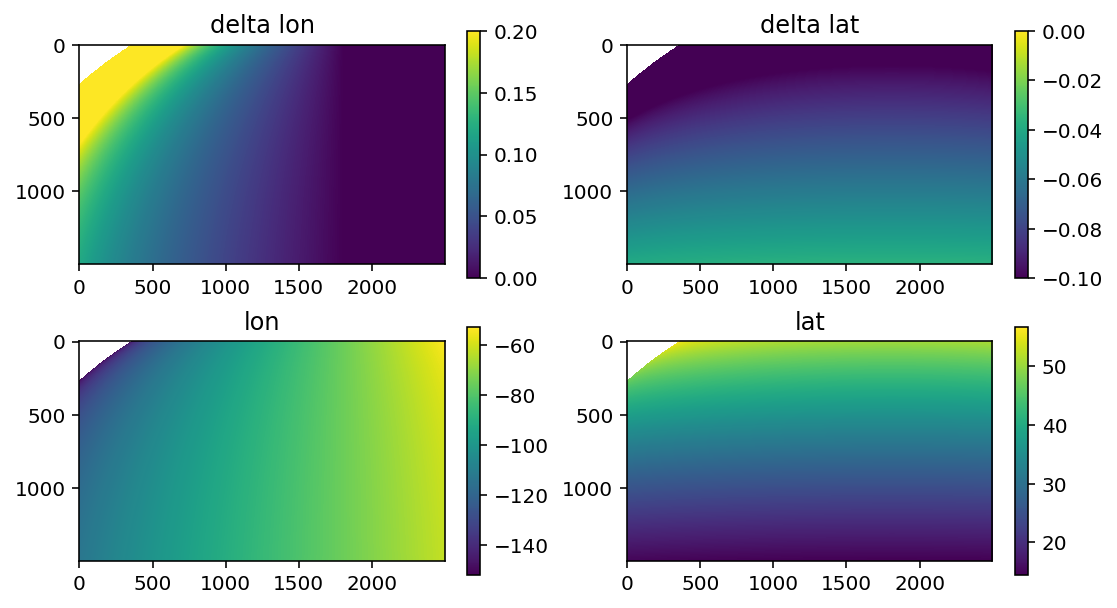

In [12]:
%matplotlib inline

# %matplotlib widget

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2, figsize=(9,5), dpi=144)

im = axs[0,0].imshow(lon_ltg - lon, vmin=0, vmax=.2)
axs[0,0].set_title('delta lon')
plt.colorbar(im, ax=axs[0,0])

im = axs[0,1].imshow(lat_ltg - lat, vmin=-0.1, vmax=0)
axs[0,1].set_title('delta lat')
plt.colorbar(im, ax=axs[0,1])

im = axs[1,1].imshow(lat_ltg)
axs[1,1].set_title('lat')
plt.colorbar(im, ax=axs[1,1])

im = axs[1,0].imshow(lon_ltg)
axs[1,0].set_title('lon')
plt.colorbar(im, ax=axs[1,0])

### Compare our calculations to the original, lightning-ellipsoid corrected GLM L2 locations

They should be the same. L2 data are plotted in squares. Define a centers_to_edges function to convert the center position of each pixel to the corner points of each pixel, as is necessary for accurately plotting those data with `pcolormesh`.


In [13]:
def centers_to_edges_2d(x):
    """ 
    Create a (N+1, M+1) array of edge locations from a
    (N, M) array of grid center locations.
    
    In the interior, the edge positions set to the midpoints
    of the values in x. For the outermost edges, half the 
    closest dx is assumed to apply. This matters for polar
    meshes, where one edge of the grid becomes a point at the
    polar coordinate origin; dx/2 is a half-hearted way of
    trying to prevent negative ranges.
    
    Useful when plotting with pcolor, which requires
    X, Y of shape (N+1) and grid center values of shape (N).
    Otherwise, pcolor silently discards the last row and column
    of grid center values.
    
    Parameters
    ----------
    x : array, shape (N,M)
        Locations of the centers 
    
    Returns
    -------
    xedge : array, shape (N+1,M+1)
    
    """
    xedge = np.zeros((x.shape[0]+1,x.shape[1]+1))
    # interior is a simple average of four adjacent centers
    xedge[1:-1,1:-1] = (x[:-1,:-1] + x[:-1,1:] + x[1:,:-1] + x[1:,1:])/4.0
    
    #         /\
    #        /\/\
    #       / /\ \
    #      /\/  \/\
    #     / /\  /\ \
    #    /\/  \/  \/\
    #   / /\  /\  /\ \
    #  /\/  \/  \/  \/\
    #4 \/\  /\  /\  /\/ 4
    # 3 \ \/  \/  \/ / 3 
    #    \/\  /\  /\/
    #   2 \ \/  \/ / 2  
    #      \/\  /\/
    #     1 \ \/ / 1
    #        \/\/
    #       0 \/ 0 = center ID of 0th dimension
    #
    
    # calculate the deltas along each edge, excluding corners
    xedge[1:-1,0] = xedge[1:-1, 1] - (xedge[1:-1, 2] - xedge[1:-1, 1])/2.0
    xedge[1:-1,-1]= xedge[1:-1,-2] - (xedge[1:-1,-3] - xedge[1:-1,-2])/2.0
    xedge[0,1:-1] = xedge[1,1:-1]  - (xedge[2,1:-1]  - xedge[1,1:-1])/2.0 
    xedge[-1,1:-1]= xedge[-2,1:-1] - (xedge[-3,1:-1] - xedge[-2,1:-1])/2.0
    
    # now do the corners
    xedge[0,0]  = xedge[1, 1] - (xedge[2, 2] - xedge[1, 1])/2.0
    xedge[0,-1] = xedge[1,-2] - (xedge[2,-3] - xedge[1,-2])/2.0
    xedge[-1,0] = xedge[-2,1] - (xedge[-3,2] - xedge[-2,1])/2.0 
    xedge[-1,-1]= xedge[-2,-2]- (xedge[-3,-3]- xedge[-2,-2])/2.0
    
    return xedge


In [14]:
lon_ltg_edge = centers_to_edges_2d(lon_ltg)
lat_ltg_edge = centers_to_edges_2d(lat_ltg)

/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in subtract
/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in subtract
/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


(-103, -98, 30, 35)

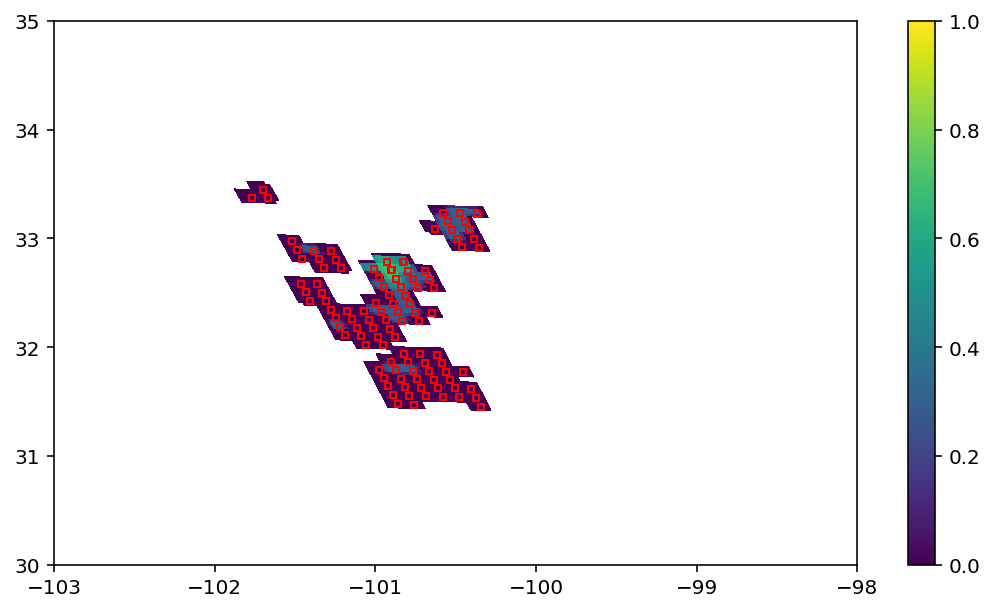

In [15]:
x_sub = slice(500, None)
y_sub = slice(None, None)

fig, ax = plt.subplots(1,1,figsize=(9,5), dpi=144)

im = ax.pcolormesh(lon_ltg_edge[y_sub, x_sub], lat_ltg_edge[y_sub, x_sub], np.log10(glm.flash_extent_density[y_sub, x_sub]), vmin=0, vmax=1.0)
plt.colorbar(im, ax=ax)

if True:
    for l2 in l2s:
        ax.plot(l2.event_lon, l2.event_lat, 
                linestyle='', marker='s', markersize=3, linewidth=0.5,
                markeredgecolor='r', markerfacecolor='none')
    
# ax.axis((-120, -65, 10, 55))
ax.axis((-103, -98, 30, 35))

### Illustrate the effect of no parallax correction

For this example, it's an offset of about 10-20 km.

In [16]:
lon_edge = centers_to_edges_2d(lon)
lat_edge = centers_to_edges_2d(lat)

/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in subtract
/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in subtract
/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars


(-103, -98, 30, 35)

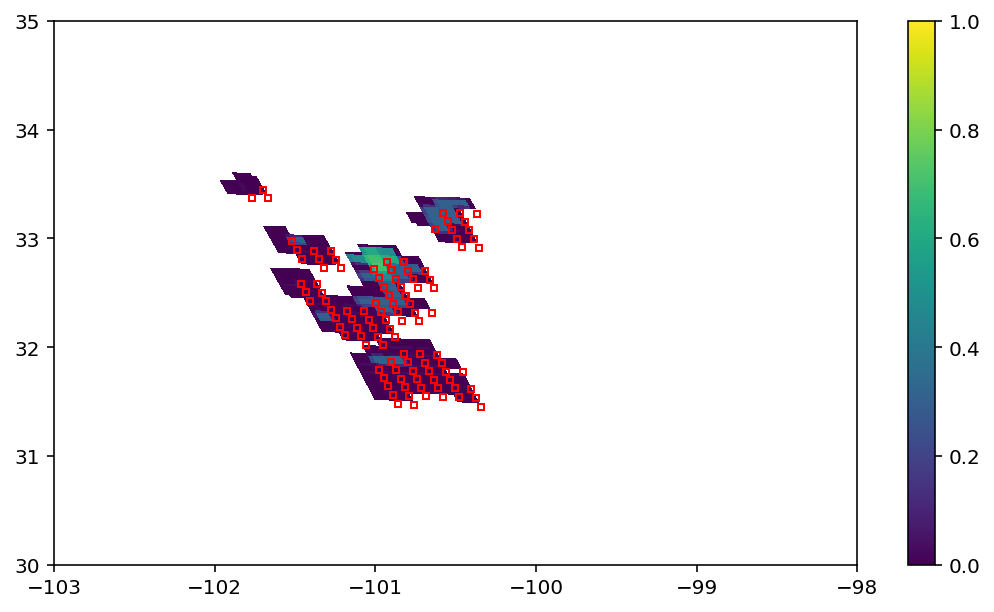

In [17]:
x_sub = slice(500, None)
y_sub = slice(None, None)

fig, ax = plt.subplots(1,1,figsize=(9,5), dpi=144)

im = ax.pcolormesh(lon_edge[y_sub, x_sub], lat_edge[y_sub, x_sub], np.log10(glm.flash_extent_density[y_sub, x_sub]), vmin=0, vmax=1.0)
plt.colorbar(im, ax=ax)

if True:
    for l2 in l2s:
        ax.plot(l2.event_lon, l2.event_lat, 
                linestyle='', marker='s', markersize=3, linewidth=0.5,
                markeredgecolor='r', markerfacecolor='none')
    
# ax.axis((-120, -65, 30, 35))
ax.axis((-103, -98, 30, 35))

### Also do a radar overlay to see if the lightning ellipsoid height does a good job

Use KLBB NEXRAD L2 data converted to NetCDF format using PyART.

In [18]:
klbb = xr.open_dataset('/Users/ebruning/Downloads/KLBB20180702_043208_V06.nc')

In [19]:
sweep_id=0
this_sweep = slice(klbb.sweep_start_ray_index[sweep_id].data, klbb.sweep_end_ray_index[sweep_id].data)
klbb_swp = klbb[{'time':this_sweep, 'sweep':sweep_id}]

from lmatools.coordinateSystems import RadarCoordinateSystem
rcs = RadarCoordinateSystem(klbb_swp.latitude.data, klbb_swp.longitude.data, klbb_swp.altitude.data)
interior_points = slice(1,-1)
r_edge = (klbb_swp.range[1:]+klbb_swp.range[:-1])/2.0 # range dim
az_edge = (klbb_swp.azimuth[1:]+klbb_swp.azimuth[:-1])/2.0 # time dim
dbz = klbb_swp.reflectivity[interior_points, interior_points]

r_mesh, az_mesh = np.meshgrid(r_edge, az_edge)
el_mesh = np.median(klbb_swp.elevation)*np.ones_like(r_mesh)

radar_lon, radar_lat, radar_alt = grs80lla.fromECEF(*rcs.toECEF(r_mesh, az_mesh, el_mesh))
radar_lon.shape=r_mesh.shape
radar_lat.shape=r_mesh.shape


(-103, -98, 30, 35)

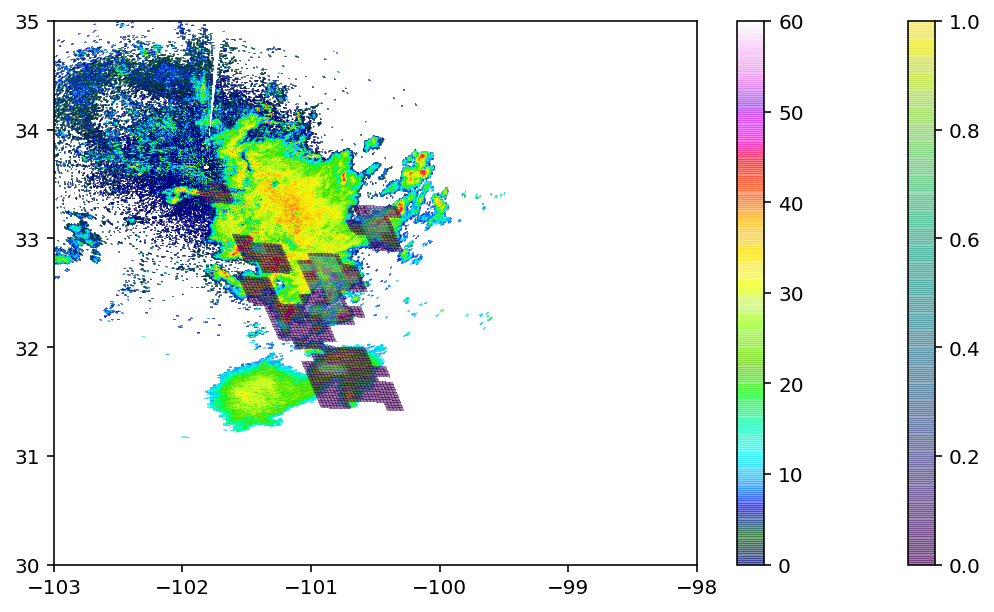

In [20]:
x_sub = slice(500, None)
y_sub = slice(None, None)

fig, ax = plt.subplots(1,1,figsize=(9,5), dpi=144)


im = ax.pcolormesh(lon_ltg_edge[y_sub, x_sub], lat_ltg_edge[y_sub, x_sub], 
                   np.log10(glm.flash_extent_density[y_sub, x_sub]), 
                   vmin=0, vmax=1.0, alpha=0.5, zorder=10)
plt.colorbar(im, ax=ax)

radar_im=ax.pcolormesh(radar_lon, radar_lat, dbz, zorder=0,
                       vmin=0, vmax=60, cmap='gist_ncar', alpha=0.5)
plt.colorbar(radar_im, ax=ax)


if False:
    for l2 in l2s:
        ax.plot(l2.event_lon, l2.event_lat, 
                linestyle='', marker='s', markersize=3, linewidth=0.5,
                markeredgecolor='r', markerfacecolor='none')

# ax.axis((-120, -65, 10, 55))
ax.axis((-103, -98, 30, 35))

### Rewriting to disk

Add the 2D arrays back to the original dataset and save to disk. This doesn't have the CF standard name metadata or unit information, but that isn't too hard to add if you need it.

In [21]:
# glm['longitude'] = xr.DataArray(lon_ltg, dims=('y', 'x'))
# glm['latitude'] = xr.DataArray(lat_ltg, dims=('y', 'x'))
# glm.to_netcdf('glm_aggregate.nc')

## Interpolating to a target grid

One might wish to interpolat to a regular latitude, longitude grid, which is a pretty standard operation given the `(lat,lon)` coordinate data provided above.

All the usual caveats (artifacts, aliasing, etc.) with interpolation apply, though as oversampled as the GLM data are, it should be possible to do a pretty good job. (GLM pixels are nominally 10 km over CONUS, but are mapped to a 2 km fixed grid). The result below does indeed look pretty good, visually.

In [22]:
dlat, dlon = 0.03, 0.03
reg_lon,reg_lat = np.meshgrid(np.arange(-103, -99, dlon), np.arange(30, 35, dlat))
reg_lat.shape #y, x dimensions

(167, 134)

In [23]:
from scipy.interpolate import griddata
interp_loc = np.vstack((reg_lat.flatten(), reg_lon.flatten())).T

# GLM variables are filled with nan everywhere there is no lightning,
# so set those locations corresponding to valid earth locations to zero.
# Also flip the north-south coordinate to match the fact that the GLM data
# coordinate begins from the upper left instead of lower right corner.
good = np.isfinite(lon_ltg[::-1, :])
data_loc = np.vstack((lat_ltg[::-1, :][good], lon_ltg[::-1, :][good])).T
interp_data = glm.flash_extent_density.data[::-1, :][good]
print(finite_max(interp_data))
interp_data[~np.isfinite(interp_data)] = 0
print(finite_max(interp_data))

21.0
21.0


In [24]:
interp_field = griddata(data_loc, interp_data, interp_loc, method='linear')
interp_field.shape = reg_lon.shape

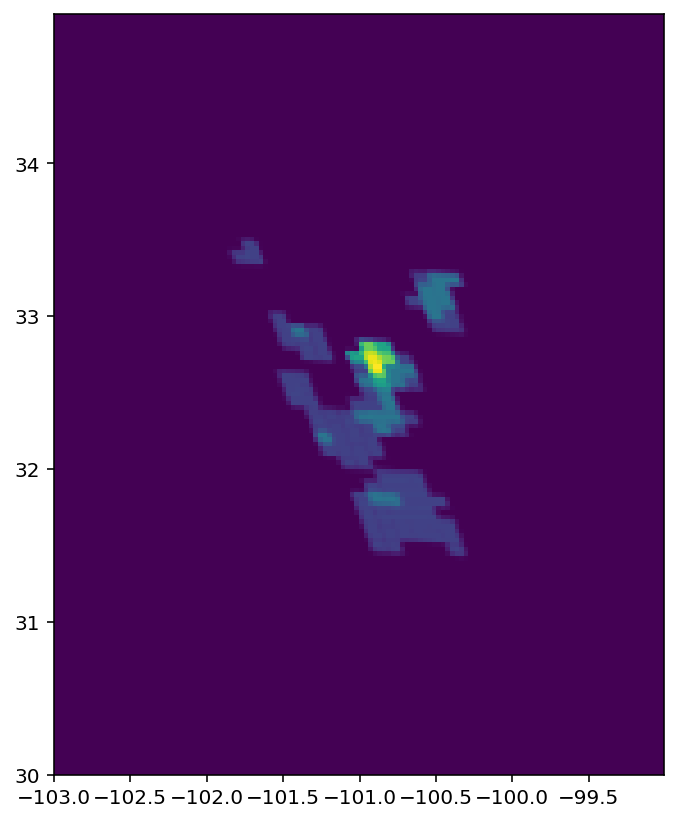

In [25]:
fig,ax = plt.subplots(1,1,figsize=(7,7), dpi=144)
plt.imshow(interp_field, extent=(reg_lon.min(), reg_lon.max(), reg_lat.min(), reg_lat.max()), origin='lower')
# ax.axis((-700,-300,650,1000))

### Interpolating to a target grid - from an NWP model projection

We can go one further, and interpolate directly from fixed grid to a model target grid.

**_This section is under development_** and the LCC coordinates derived here don't quite match the model. However, the interpolation looks pretty nice, so it's probably some small bug.

The coordinate information for the [2.5 km HRRR run by NCEP is](https://thredds.ucar.edu/thredds/catalog/grib/NCEP/HRRR/CONUS_2p5km_ANA/latest.html) is in the Lambert Conformal projection on yet another earth ellipsoid - this time, spherical.

We can use the siphon module to download a single variable and its coordinate information. Just use xr.open_dataset if you have the NetCDF data locally.

In [73]:
from siphon.catalog import TDSCatalog
from datetime import datetime

vtime = datetime.strptime('2020020219','%Y%m%d%H')
model_url = "https://thredds.ucar.edu/thredds/catalog/grib/NCEP/HRRR/CONUS_2p5km_ANA/latest.html?dataset=grib/NCEP/HRRR/CONUS_2p5km_ANA/HRRR_CONUS_2p5km_ana_20200202_1900.grib2"

model = TDSCatalog(model_url)
ds = model.datasets[0]
ncss = ds.subset()
query = ncss.query()
query.accept('netcdf4')
query.time(vtime) # Set to the analysis hour only
query.add_lonlat()
query.variables('Categorical_freezing_rain_surface')
# 'x', 'y', 'LambertConformal_Projection', etc. come along for free.
data = ncss.get_data(query)

In [77]:
hrrr = xr.open_dataset(xr.backends.NetCDF4DataStore(data))

In [183]:
print(hrrr.LambertConformal_Projection)
print('-----')
print(hrrr.x)
print('-----')
print(hrrr.y)

<xarray.DataArray 'LambertConformal_Projection' ()>
array(0, dtype=int32)
Attributes:
    grid_mapping_name:              lambert_conformal_conic
    latitude_of_projection_origin:  25.0
    longitude_of_central_meridian:  265.0
    standard_parallel:              25.0
    earth_radius:                   6371229.0
    _CoordinateTransformType:       Projection
    _CoordinateAxisTypes:           GeoX GeoY
-----
<xarray.DataArray 'x' (x: 2145)>
array([-2763.217 , -2760.6772, -2758.1377, ...,  2676.8267,  2679.3662,
        2681.906 ], dtype=float32)
Coordinates:
  * x        (x) float32 -2763.217 -2760.6772 -2758.1377 ... 2679.3662 2681.906
Attributes:
    standard_name:        projection_x_coordinate
    units:                km
    _CoordinateAxisType:  GeoX
-----
<xarray.DataArray 'y' (y: 1377)>
array([-263.79062, -261.25092, -258.7112 , ..., 3225.7612 , 3228.3008 ,
       3230.8406 ], dtype=float32)
Coordinates:
  * y        (y) float32 -263.79062 -261.25092 -258.7112 ... 3228.3008 

In [91]:
hrrrproj={
'lat_0':hrrr.LambertConformal_Projection.latitude_of_projection_origin,
'lon_0':hrrr.LambertConformal_Projection.longitude_of_central_meridian,
'lat_1':hrrr.LambertConformal_Projection.standard_parallel,
'R':hrrr.LambertConformal_Projection.earth_radius,
}

from lmatools.coordinateSystems import MapProjection
lcc = MapProjection(projection='lcc', ctrLat=hrrrproj['lat_0'],ctrLon=hrrrproj['lon_0'], **hrrrproj)

In [94]:
lccx,lccy,lccz = lcc.fromECEF(*geofix_ltg.toECEF(x,y,z))
lccx.shape=x.shape
lccy.shape=y.shape

In [165]:
lccx.shape, glm.flash_extent_density.shape

((1500, 2500), (1500, 2500))

The result of the above calculation is the exact center location of each image pixel in fixed grid coordiantes. As shown in the plot below, this results in an exact mapping of the GLM CCD pixel shapes to the LCC grid. This can be used to drive an interpoation to the LCC model grid. 

In [184]:
lccx_edge = centers_to_edges_2d(lccx)
lccy_edge = centers_to_edges_2d(lccy)
fig,ax = plt.subplots(1,1,figsize=(9,7), dpi=144)
ax.pcolormesh(lccx_edge[y_sub,x_sub]/1000.0, lccy_edge[y_sub,x_sub]/1000.0, glm.flash_extent_density[y_sub,x_sub])
ax.axis((-700,-300,650,1000))

/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in subtract
/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in subtract
/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-700, -300, 650, 1000)

In [177]:
from scipy.interpolate import griddata
hrrrx, hrrry = np.meshgrid(hrrr.x, hrrr.y)
interp_loc = np.vstack((hrrrx.flatten(), hrrry.flatten())).T

# GLM variables are filled with nan everywhere there is no lightning,
# so set those locations corresponding to valid earth locations to zero.
# Also flip the north-south coordinate to match the fact that the GLM data
# coordinate begins from the upper left instead of lower right corner.
good = np.isfinite(lccx[::-1,:])
data_loc = np.vstack((lccx [good]/1e3, lccy[::-1,:][good]/1e3)).T
interp_data = glm.flash_extent_density.data[good]
print(interp_data.max())
interp_data[~np.isfinite(interp_data)] = 0

interp_field = griddata(data_loc, interp_data, interp_loc, method='linear')

nan


In [178]:
interp_field.shape=hrrrx.shape

In [179]:
print(interp_data.max())
print(data_loc[:,0].min(), data_loc[:,0].max(), data_loc[:,1].min(), data_loc[:,1].max())
print(interp_loc[:,0].min(), interp_loc[:,0].max(), interp_loc[:,1].min(), interp_loc[:,1].max())

print(good.sum(), (~good).sum(), np.isfinite(interp_data).sum())
print(hrrr.x.shape)
print(hrrrx.shape)
print(finite_max(interp_field))
print(interp_loc.shape)

21.0
-4085.3850344459706 3659.2199259402887 -1165.7111010431006 4440.781304788785
-2763.217 2681.906 -263.79062 3230.8406
3704272 45728 3704272
(2145,)
(1377, 2145)
21.000000000000004
(2953665, 2)


In [180]:
fig,ax = plt.subplots(1,1,figsize=(9,7), dpi=144)
plt.imshow(interp_field, extent=(hrrrx.min(), hrrrx.max(), hrrry.min(), hrrry.max()))
# ax.axis((-700,-300,650,1000))

/Users/ebruning/miniconda3/envs/glmval/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …